In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from scipy.stats import multivariate_normal
from scipy.special import softmax

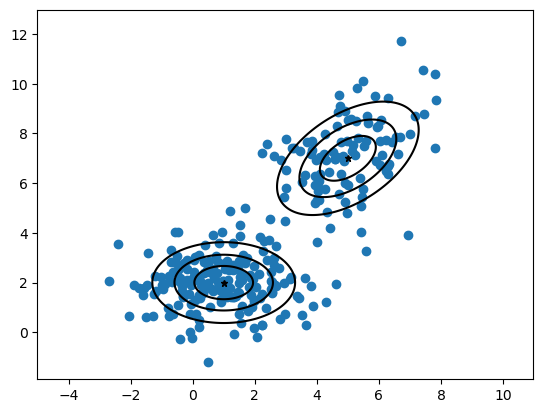

In [2]:
def plot_2dnormal(normal, color):
    # plot center
    plt.plot(normal.mean[0], normal.mean[1], '*', ms=5, color=color)

    # get countour grid
    x, y = np.mgrid[-3:3:.01, -3:3:.01]
    
    # rescale x, y
    x = normal.cov[0,0] * x + normal.mean[0]
    y = normal.cov[1,1] * y + normal.mean[1]
    
    # plot countour
    pos = np.dstack((x, y)) 
    plt.contour(x, y, normal.pdf(pos), colors=color, levels=3)

# mixture weights
weights = [0.7, 0.3]

# mixture components
component1 = multivariate_normal(mean=[1, 2], cov=[[2, 0], [0, 1]])
component2 = multivariate_normal(mean=[5, 7], cov=[[2, 1], [1, 2]])
components = [component1, component2]

# sample N = 300 samples from the Gaussian mixture model
np.random.seed(1234) # for reproducibility
N = 300
X = np.stack([np.random.choice(components, p=weights).rvs() for _ in range(N)])

plt.figure()
plt.scatter(X[:,0], X[:,1])
plot_2dnormal(component1, color='black')
plot_2dnormal(component2, color='black')
plt.show()

In [8]:
X.shape

(300, 2)

In [3]:
def e_step(X, weights, components):
    unnormalized_logprobs = [
        np.log(w) + component.logpdf(X) for w, component in zip(weights, components)
    ]
    probs_matrix = softmax(np.vstack(unnormalized_logprobs), axis=0)
    return probs_matrix

In [4]:
def m_step(X, probs):
    
    sum_probs = probs.sum(axis=1)
    
    weights = sum_probs / probs.shape[1]
    mus = (probs @ X) / sum_probs[:, None]
    centeredX = X - mus[:, None, :]
    probs_centeredX = probs[..., None] * centeredX
    covs = (probs_centeredX.transpose(0,2,1) @ centeredX) / sum_probs[:, None, None]
    
    components = [
        multivariate_normal(mean=mu, cov=cov) for mu, cov in zip(mus, covs)
    ]
    
    return weights, components

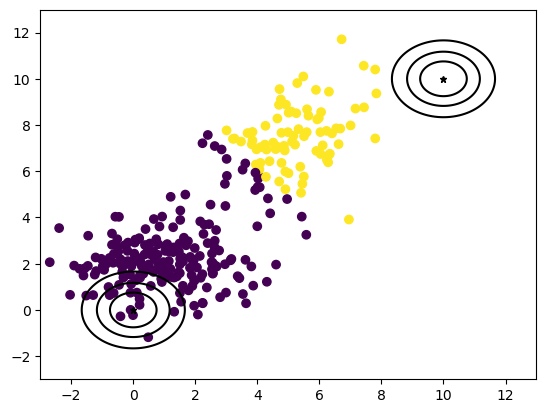

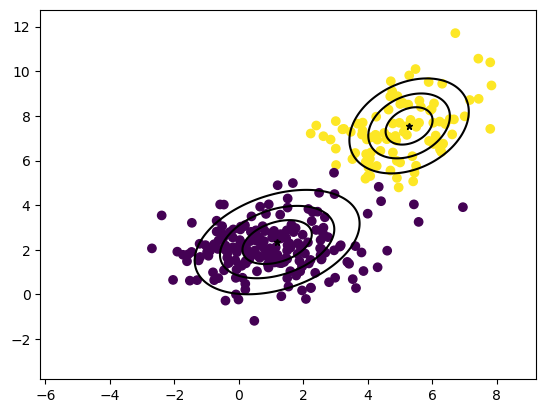

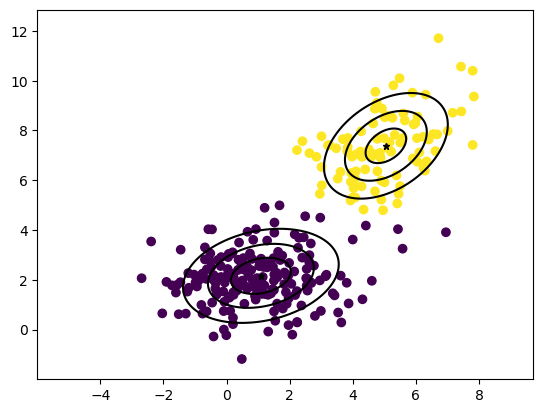

In [9]:
# initial parameter estimates
component1_estimated = multivariate_normal(mean=[0, 0], cov=np.eye(2))
component2_estimated  = multivariate_normal(mean=[10, 10], cov=np.eye(2))
components_estimated = [component1_estimated, component2_estimated]
weights_estimated = [0.5, 0.5]

for i in range(3):    
    # expectation step
    probs = e_step(X, weights_estimated, components_estimated)
    belong_to = probs.argmax(axis=0)
    
    # plot estimates
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1])
    for c in components_estimated:
        plot_2dnormal(c, color='black')
    plt.show()
    
    # maximization step
    weights_estimated, components_estimated = m_step(X, probs)

In [6]:
print('weights:')
print(weights_estimated)
for i, c in enumerate(components_estimated):
    print('')
    print('Normal {}'.format(i+1))
    print('- mean:')
    print(c.mean)
    print('- cov:')
    print(c.cov)

weights:
[0.67675646 0.32324354]

Normal 1
- mean:
[1.00995651 2.06383234]
- cov:
[[2.19105634 0.19425555]
 [0.19425555 1.07298866]]

Normal 2
- mean:
[4.96813911 7.26889501]
- cov:
[[1.62557968 0.76820486]
 [0.76820486 1.96894681]]
